## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

* 依照前幾天資料分析的結果，將各個regularization組合中，參數拿做組合建模(主選train&valid差距小的)
* Day 81 - regularizers: L1 (1e-4, 1e-8)
* Day 82 - dropout (0.1, 0.2)
* Day 83 - batch-normalization (32, 128)
* 由結果可以觀察到 batch-128; L1-1e-8, dropout-0.1時準確度為組合內參數最佳。

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
MOMENTUM = 0.95
BATCH_SIZE = [32, 128] 
L1_EXP = [1e-4, 1e-8]
Dropout_EXP = [0.1, 0.2]

In [6]:
from keras.regularizers import l1, l2, l1_l2
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras import regularizers

#建立神經網路

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=1e-4, drp_ratio=0.2):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=regularizers.l1(l1_ratio))(input_layer)
            x = Dropout(drp_ratio)(x)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=regularizers.l1(l1_ratio))(x)
            x = Dropout(drp_ratio)(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:
import itertools

results = {}
# 使用迴圈建立不同的regularization 的組合模型並訓練

for bs, l1, dp in itertools.product(BATCH_SIZE, L1_EXP, Dropout_EXP):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with BATCH_SIZE = %.f" % (bs) + ", and L1 Regulizer = %.8f" % (l1) + ", and Dropout = %.1f" % (dp))
    model = build_mlp(input_shape=x_train.shape[1:], l1_ratio=l1, drp_ratio=dp)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=bs, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-BATCH_SIZE-%s" % str(bs) + ", exp-l1-%s" % str(l1)+ ", exp-Dropout-%s" % str(dp)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


W0806 23:25:16.115305 46220 deprecation_wrapper.py:119] From E:\Users\moon\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0806 23:25:16.117305 46220 deprecation_wrapper.py:119] From E:\Users\moon\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0806 23:25:16.143306 46220 deprecation_wrapper.py:119] From E:\Users\moon\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0806 23:25:16.145307 46220 deprecation_wrapper.py:119] From E:\Users\moon\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0806 23:25:16.147307 46220 depr

Experiment with BATCH_SIZE = 32, and L1 Regulizer = 0.00010000, and Dropout = 0.1


W0806 23:25:16.546330 46220 deprecation_wrapper.py:119] From E:\Users\moon\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0806 23:25:16.680337 46220 deprecation.py:323] From E:\Users\moon\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
__________

50000/50000 [==============================] - 44s 880us/step - loss: 3.2735 - acc: 0.3225 - val_loss: 3.0561 - val_acc: 0.3442
Epoch 8/25
50000/50000 [==============================] - 45s 903us/step - loss: 2.9956 - acc: 0.3284 - val_loss: 2.8028 - val_acc: 0.3611
Epoch 9/25
50000/50000 [==============================] - 45s 900us/step - loss: 2.7508 - acc: 0.3403 - val_loss: 2.6745 - val_acc: 0.3165
Epoch 10/25
50000/50000 [==============================] - 45s 893us/step - loss: 2.5430 - acc: 0.3479 - val_loss: 2.4008 - val_acc: 0.3587
Epoch 11/25
50000/50000 [==============================] - 58s 1ms/step - loss: 2.4026 - acc: 0.3495 - val_loss: 2.2932 - val_acc: 0.3765
Epoch 12/25
50000/50000 [==============================] - 90s 2ms/step - loss: 2.2990 - acc: 0.3476 - val_loss: 2.1668 - val_acc: 0.3923
Epoch 13/25
50000/50000 [==============================] - 90s 2ms/step - loss: 2.2094 - acc: 0.3530 - val_loss: 2.6087 - val_acc: 0.2512
Epoch 14/25
50000/50000 [===============

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 78s 2ms/step - loss: 2.0166 - acc: 0.2839 - val_loss: 1.7969 - val_acc: 0.3643
Epoch 2/25
50000/50000 [==============================] - 79s 2ms/step - loss: 1.8388 - acc: 0.3331 - val_loss: 1.7049 - val_acc: 0.3842
Epoch 3/25
50000/50000 [==============================] - 82s 2ms/step - loss: 1.8292 - acc: 0.3365 - val_loss: 1.7721 - val_acc: 0.3520
Epoch 4/25
50000/50000 [==============================] - 82s 2ms/step - loss: 1.8230 - acc: 0.3397 - val_loss: 1.6977 - val_acc: 0.3895
Epoch 5/25
50000/50000 [==============================] - 73s 1ms/step - loss: 1.8127 - acc: 0.3450 - val_loss: 1.8892 - val_acc: 0.3279
Epoch 6/25
50000/50000 [==============================] - 43s 853us/step - loss: 1.8177 - acc: 0.3404 - val_loss: 1.7842 - val_acc: 0.3578
Epoch 7/25
50000/50000 [==============================] - 43s 852us/step - loss: 1.8042 - acc: 0.3455 - val_loss: 1.6764 - val

50000/50000 [==============================] - 16s 311us/step - loss: 3.3622 - acc: 0.4781 - val_loss: 3.5612 - val_acc: 0.3917
Epoch 21/25
50000/50000 [==============================] - 16s 311us/step - loss: 3.2670 - acc: 0.4816 - val_loss: 3.3544 - val_acc: 0.4277
Epoch 22/25
50000/50000 [==============================] - 16s 312us/step - loss: 3.1736 - acc: 0.4851 - val_loss: 3.2090 - val_acc: 0.4615
Epoch 23/25
50000/50000 [==============================] - 15s 306us/step - loss: 3.0936 - acc: 0.4862 - val_loss: 3.1405 - val_acc: 0.4568
Epoch 24/25
50000/50000 [==============================] - 16s 311us/step - loss: 3.0060 - acc: 0.4919 - val_loss: 3.0555 - val_acc: 0.4582
Epoch 25/25
50000/50000 [==============================] - 16s 311us/step - loss: 2.9388 - acc: 0.4912 - val_loss: 3.0096 - val_acc: 0.4614
Experiment with BATCH_SIZE = 128, and L1 Regulizer = 0.00010000, and Dropout = 0.2
_________________________________________________________________
Layer (type)           

50000/50000 [==============================] - 29s 587us/step - loss: 1.9940 - acc: 0.3150 - val_loss: 1.7202 - val_acc: 0.3815
Epoch 2/25
50000/50000 [==============================] - 27s 536us/step - loss: 1.7090 - acc: 0.3933 - val_loss: 1.6380 - val_acc: 0.4135
Epoch 3/25
50000/50000 [==============================] - 29s 583us/step - loss: 1.6295 - acc: 0.4189 - val_loss: 1.5929 - val_acc: 0.4291
Epoch 4/25
50000/50000 [==============================] - 29s 579us/step - loss: 1.5826 - acc: 0.4343 - val_loss: 1.5862 - val_acc: 0.4407
Epoch 5/25
50000/50000 [==============================] - 28s 566us/step - loss: 1.5575 - acc: 0.4439 - val_loss: 1.5702 - val_acc: 0.4369
Epoch 6/25
50000/50000 [==============================] - 30s 594us/step - loss: 1.5353 - acc: 0.4540 - val_loss: 1.4926 - val_acc: 0.4665
Epoch 7/25
50000/50000 [==============================] - 28s 559us/step - loss: 1.5104 - acc: 0.4633 - val_loss: 1.5366 - val_acc: 0.4439
Epoch 8/25
50000/50000 [==============

Epoch 21/25
50000/50000 [==============================] - 16s 314us/step - loss: 1.5048 - acc: 0.4584 - val_loss: 1.4398 - val_acc: 0.4836
Epoch 22/25
50000/50000 [==============================] - 16s 314us/step - loss: 1.5040 - acc: 0.4609 - val_loss: 1.4621 - val_acc: 0.4748
Epoch 23/25
50000/50000 [==============================] - 16s 314us/step - loss: 1.4894 - acc: 0.4665 - val_loss: 1.4510 - val_acc: 0.4782
Epoch 24/25
50000/50000 [==============================] - 16s 314us/step - loss: 1.4914 - acc: 0.4667 - val_loss: 1.4762 - val_acc: 0.4680
Epoch 25/25
50000/50000 [==============================] - 16s 314us/step - loss: 1.4837 - acc: 0.4660 - val_loss: 1.4657 - val_acc: 0.4785


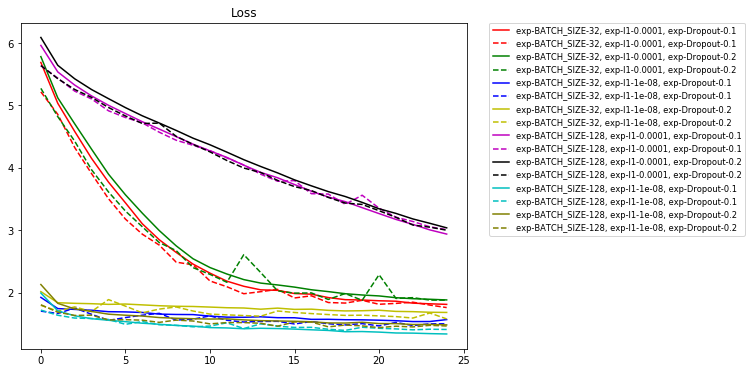

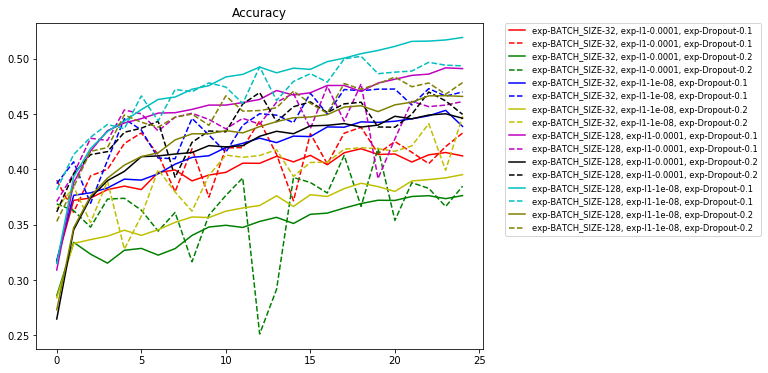

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k", "c", "olive"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize='small')
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize='small')
plt.show()